In [3]:
# Cell 1: Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print("All libraries imported successfully!")

All libraries imported successfully!


In [6]:
# Load preprocessed dataset
import pandas as pd
file_path = '/content/drive/MyDrive/CNN/reddit_mental_health_dataset_fengg1.csv'
df = pd.read_csv(file_path)


In [7]:
# Cell 2: Data preparation
def prepare_data(df):
    print("Initial Dataset Shape:", df.shape)
    df.dropna(subset=['clean_text'], inplace=True)
    print("After Dropping Missing Values:", df.shape)

    # Encode disorders
    encoder = LabelEncoder()
    df['disorder_encoded'] = encoder.fit_transform(df['disorder'])
    num_classes = len(encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {list(encoder.classes_)}")

    return df, encoder, num_classes

# Example usage:
df, encoder, num_classes = prepare_data(df)

Initial Dataset Shape: (44559, 19)
After Dropping Missing Values: (44413, 19)
Number of classes: 12
Classes: ['ADHD', 'Anxiety', 'BPD', 'Bipolar', 'Depression', 'EatingDisorders', 'Normal', 'OCD', 'PTSD', 'Schizophrenia', 'Stress', 'SuicideWatch']


In [9]:
# Cell 3: Balance dataset
def balance_dataset(df, target_samples=4000):
    balanced_df = []
    for label in df['disorder_encoded'].unique():
        samples = df[df['disorder_encoded'] == label]
        balanced_samples = resample(samples, replace=True, n_samples=target_samples, random_state=42)
        balanced_df.append(balanced_samples)

    df_balanced = pd.concat(balanced_df)
    print("After Balancing Dataset:", df_balanced.shape)
    print(f"Each class now has {target_samples} samples")

    return df_balanced

# Example usage:
df_balanced = balance_dataset(df)

After Balancing Dataset: (48000, 19)
Each class now has 4000 samples


In [10]:
# Cell 4: Split data
def split_data(df_balanced):
    X_train, X_test, y_train, y_test = train_test_split(
        df_balanced['clean_text'],
        df_balanced['disorder_encoded'],
        test_size=0.2,
        random_state=42
    )
    print("Training Set Size:", X_train.shape)
    print("Test Set Size:", X_test.shape)

    return X_train, X_test, y_train, y_test

# Example usage:
X_train, X_test, y_train, y_test = split_data(df_balanced)

Training Set Size: (38400,)
Test Set Size: (9600,)


In [11]:
# Cell 5: Tokenize and pad sequences
def tokenize_pad_sequences(X_train, X_test, num_classes, y_train, y_test):
    # Convert labels to categorical for neural network
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Text preprocessing for CNN
    MAX_NUM_WORDS = 20000
    MAX_SEQUENCE_LENGTH = 200
    EMBEDDING_DIM = 100

    # Create and fit tokenizer
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    print(f"Found {len(word_index)} unique tokens.")

    # Convert texts to sequences and pad
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

    print(f"Training data shape after padding: {X_train_pad.shape}")
    print(f"Testing data shape after padding: {X_test_pad.shape}")

    return X_train_pad, X_test_pad, y_train_cat, y_test_cat, tokenizer, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM

# Example usage:
X_train_pad, X_test_pad, y_train_cat, y_test_cat, tokenizer, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = tokenize_pad_sequences(X_train, X_test, num_classes, y_train, y_test)

Found 45785 unique tokens.
Training data shape after padding: (38400, 200)
Testing data shape after padding: (9600, 200)


In [ ]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

In [12]:
# Fixed Cell 6: Build CNN model with explicit input shape
def build_cnn_model(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, num_classes):
    model = Sequential()

    # Embedding layer with explicit input shape
    model.add(Embedding(input_dim=MAX_NUM_WORDS,
                        output_dim=EMBEDDING_DIM,
                        input_length=MAX_SEQUENCE_LENGTH,
                        input_shape=(MAX_SEQUENCE_LENGTH,)))  # Add explicit input shape

    # Convolutional layer with global max pooling
    model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Explicitly build the model
    model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

    print("CNN model built successfully!")
    return model

# Example usage:
cnn_model = build_cnn_model(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, num_classes)
print(cnn_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CNN model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,082,188 (7.94 MB)

 Trainable params: 2,082,188 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# Cell 7: Train the model
def train_model(model, X_train_pad, y_train_cat, epochs=100, batch_size=32):
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    print(f"Training model with {epochs} epochs and batch size of {batch_size}...")
    history = model.fit(
        X_train_pad, y_train_cat,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    print("Model training completed!")
    return model, history

# Example usage:
cnn_model, history = train_model(cnn_model, X_train_pad, y_train_cat)

Training model with 100 epochs and batch size of 32...
Epoch 1/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 88s 90ms/step - accuracy: 0.4172 - loss: 1.7845 - val_accuracy: 0.7434 - val_loss: 0.8530
Epoch 2/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.8210 - loss: 0.5836 - val_accuracy: 0.8220 - val_loss: 0.6337
Epoch 3/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.9511 - loss: 0.1874 - val_accuracy: 0.8361 - val_loss: 0.6554
Epoch 4/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 87s 90ms/step - accuracy: 0.9895 - loss: 0.0534 - val_accuracy: 0.8415 - val_loss: 0.7387
Epoch 5/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.9970 - loss: 0.0204 - val_accuracy: 0.8323 - val_loss: 0.8447
Model training completed!


In [22]:
# Cell 8: Evaluate the model
def evaluate_model(model, X_test_pad, y_test, encoder):
    print("Evaluating model performance...")
    y_pred_prob = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_decoded = y_test.values

    # Calculate metrics
    accuracy = accuracy_score(y_test_decoded, y_pred)
    f1 = f1_score(y_test_decoded, y_pred, average='weighted')

    print("\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_decoded, y_pred, target_names=encoder.classes_))

    return accuracy, f1

# Example usage:
accuracy, f1 = evaluate_model(cnn_model, X_test_pad, y_test, encoder)

Evaluating model performance...
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Model Performance:
Accuracy: 0.8187
F1 Score (Weighted): 0.8196

Classification Report:
                 precision    recall  f1-score   support

           ADHD       0.85      0.88      0.86       814
        Anxiety       0.80      0.78      0.79       830
            BPD       0.77      0.79      0.78       781
        Bipolar       0.87      0.84      0.85       745
     Depression       0.63      0.72      0.67       794
EatingDisorders       0.92      0.94      0.93       787
         Normal       0.77      0.81      0.79       807
            OCD       0.87      0.86      0.87       794
           PTSD       0.90      0.80      0.85       820
  Schizophrenia       0.85      0.82      0.83       814
         Stress       0.86      0.84      0.85       807
   SuicideWatch       0.77      0.75      0.76       807

       accuracy                           0.82      9600
      macro avg       0.82      0.82 

In [23]:
# Cell 9: Create prediction function
def create_prediction_function(model, tokenizer, encoder, MAX_SEQUENCE_LENGTH):
    def predict_disorder(text):
        print(f"\nAnalyzing text: '{text}'")
        # Preprocess the text
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

        # Get prediction probabilities
        prediction = model.predict(padded_sequence)[0]

        # Get top predictions
        top_indices = prediction.argsort()[-3:][::-1]
        results = []

        print("Top 3 predictions:")
        for idx in top_indices:
            disorder = encoder.classes_[idx]
            probability = prediction[idx] * 100
            results.append((disorder, probability))
            print(f"{disorder}: {probability:.2f}%")

        return results

    print("Prediction function created!")
    return predict_disorder

# Example usage:
predict_disorder = create_prediction_function(cnn_model, tokenizer, encoder, MAX_SEQUENCE_LENGTH)

Prediction function created!


In [24]:
# Cell 10: Save the model
def save_model(model, filename='cnn_mental_disorder_model_1.h5'):
    try:
        model.save(filename)
        print(f"\nModel saved successfully as '{filename}'!")
    except Exception as e:
        print(f"\nCouldn't save model: {e}")

# Example usage:
save_model(cnn_model)


Model saved successfully as 'cnn_mental_disorder_model_1.h5'!


In [20]:
# Cell 11: Example usage
def test_prediction(predict_disorder_func):
    print("\nTesting with sample text:")
    sample_text = "I feel extremely anxious and worried all the time, I can't seem to control these feelings."
    results = predict_disorder_func(sample_text)
    return results

# Example usage:
test_results = test_prediction(predict_disorder)


Testing with sample text:

Analyzing text: 'I feel extremely anxious and worried all the time, I can't seem to control these feelings.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Top 3 predictions:
Schizophrenia: 8.77%
Bipolar: 8.60%
Anxiety: 8.56%


In [14]:
# Cell 13: Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

print("Visualization libraries imported successfully!")

Visualization libraries imported successfully!


Plotting training history...


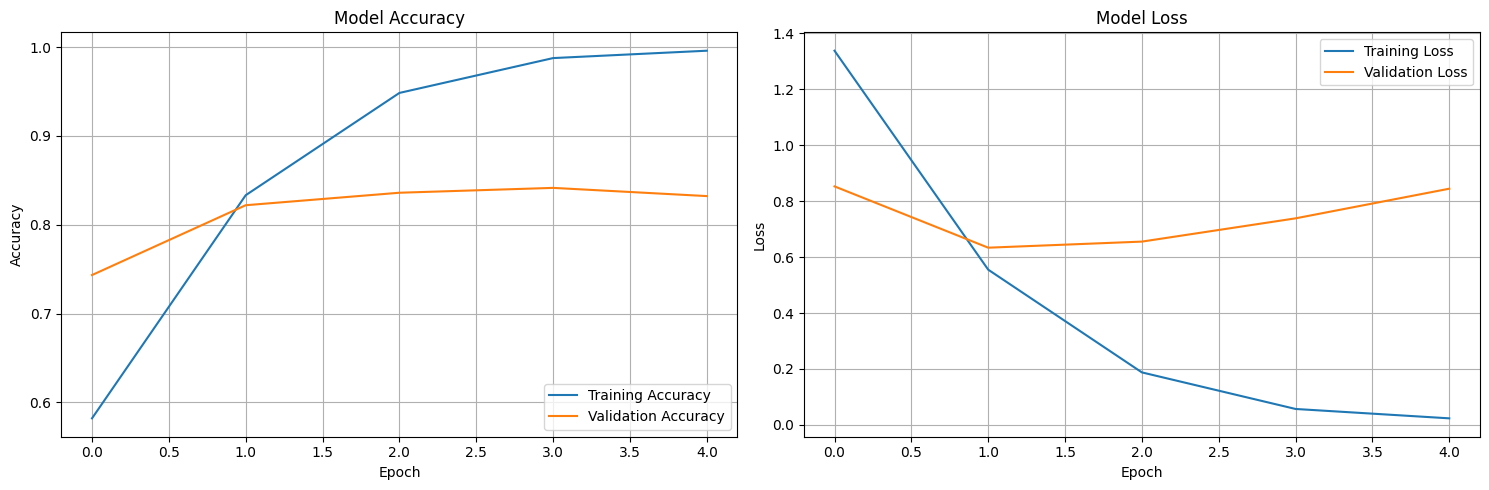

Final training accuracy: 0.9960
Final validation accuracy: 0.8323
Final training loss: 0.0231
Final validation loss: 0.8447


In [25]:
# Cell 14: Create training history visualization
def plot_training_history(history):
    """
    Plot the training and validation accuracy/loss curves
    """
    print("Plotting training history...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Example usage:
plot_training_history(history)

Generating confusion matrix...
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


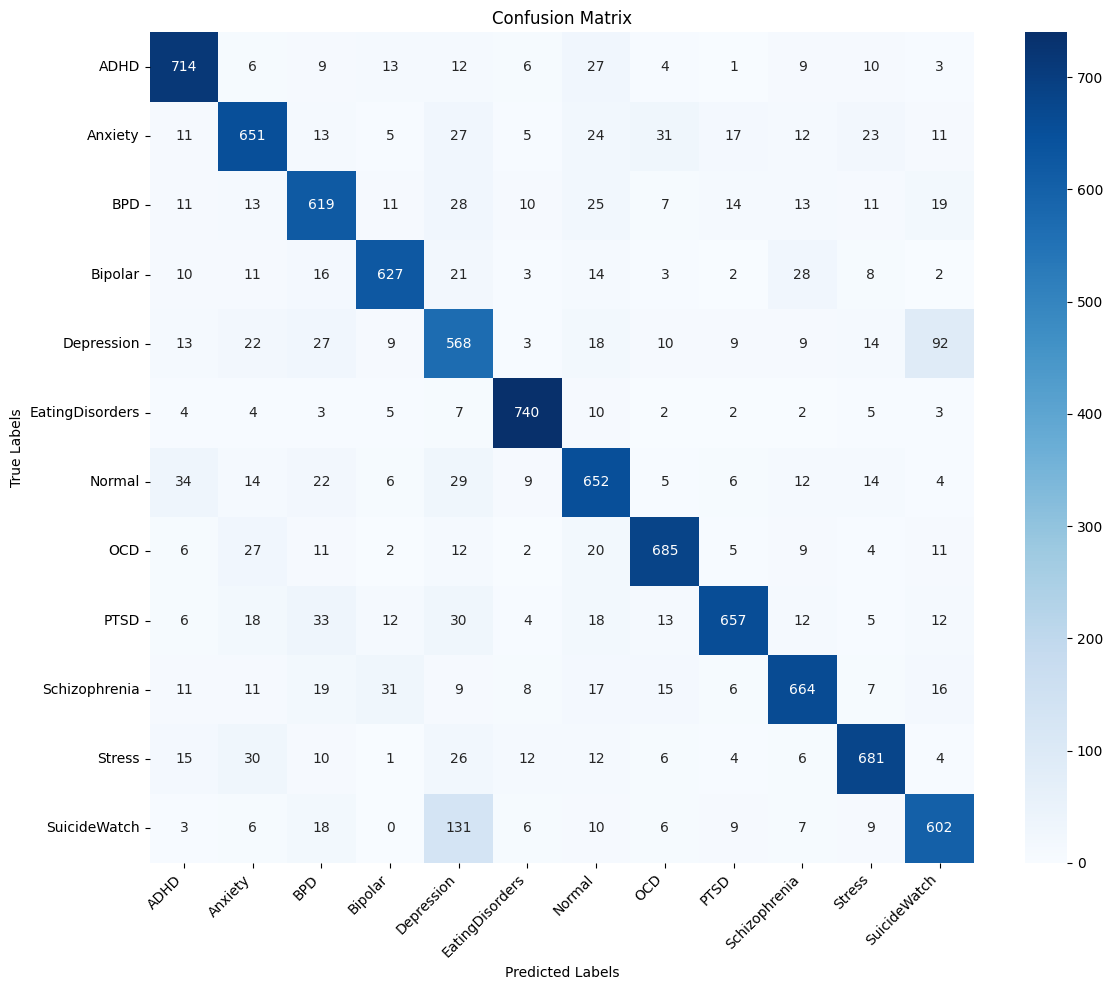


Class-wise accuracy:
ADHD: 0.8771
Anxiety: 0.7843
BPD: 0.7926
Bipolar: 0.8416
Depression: 0.7154
EatingDisorders: 0.9403
Normal: 0.8079
OCD: 0.8627
PTSD: 0.8012
Schizophrenia: 0.8157
Stress: 0.8439
SuicideWatch: 0.7460


In [26]:
# Cell 15: Create confusion matrix visualization
def plot_confusion_matrix(model, X_test_pad, y_test, encoder):
    """
    Compute and plot confusion matrix
    """
    print("Generating confusion matrix...")

    # Get predictions
    y_pred_prob = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_decoded = y_test.values

    # Compute confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Calculate and print class-wise accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\nClass-wise accuracy:")
    for i, class_name in enumerate(encoder.classes_):
        print(f"{class_name}: {class_accuracy[i]:.4f}")

# Example usage:
plot_confusion_matrix(cnn_model, X_test_pad, y_test, encoder)

Generating ROC curves...
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


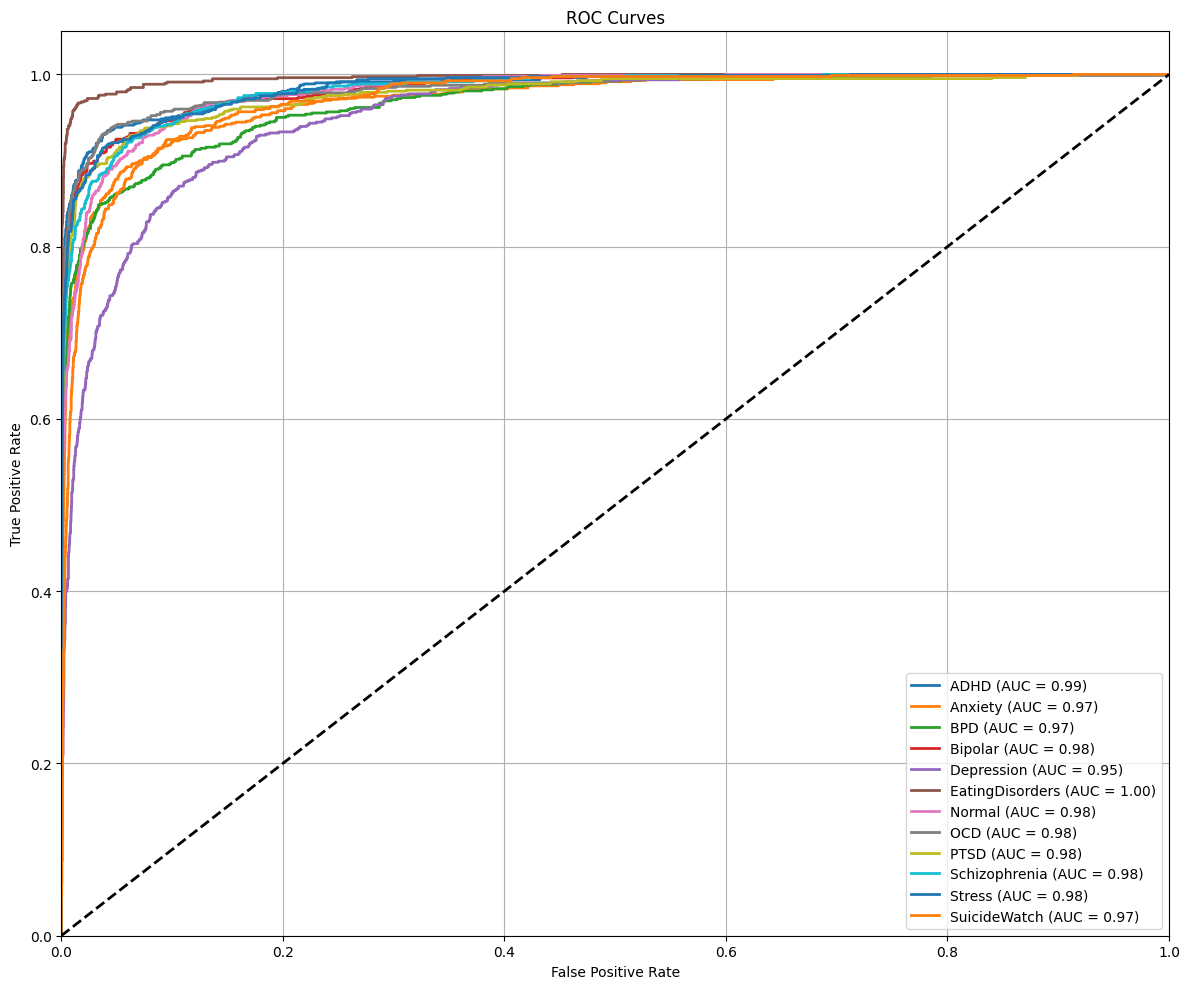

In [27]:
# Cell 16: Plot ROC curves
def plot_roc_curves(model, X_test_pad, y_test, encoder):
    """
    Plot ROC curves for each class
    """
    print("Generating ROC curves...")

    # Get predictions
    y_pred_prob = model.predict(X_test_pad)
    y_test_cat = to_categorical(y_test.values, num_classes=len(encoder.classes_))

    # Plot ROC curve for each class
    plt.figure(figsize=(12, 10))

    for i, class_name in enumerate(encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_curves(cnn_model, X_test_pad, y_test, encoder)

Generating precision-recall curves...
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


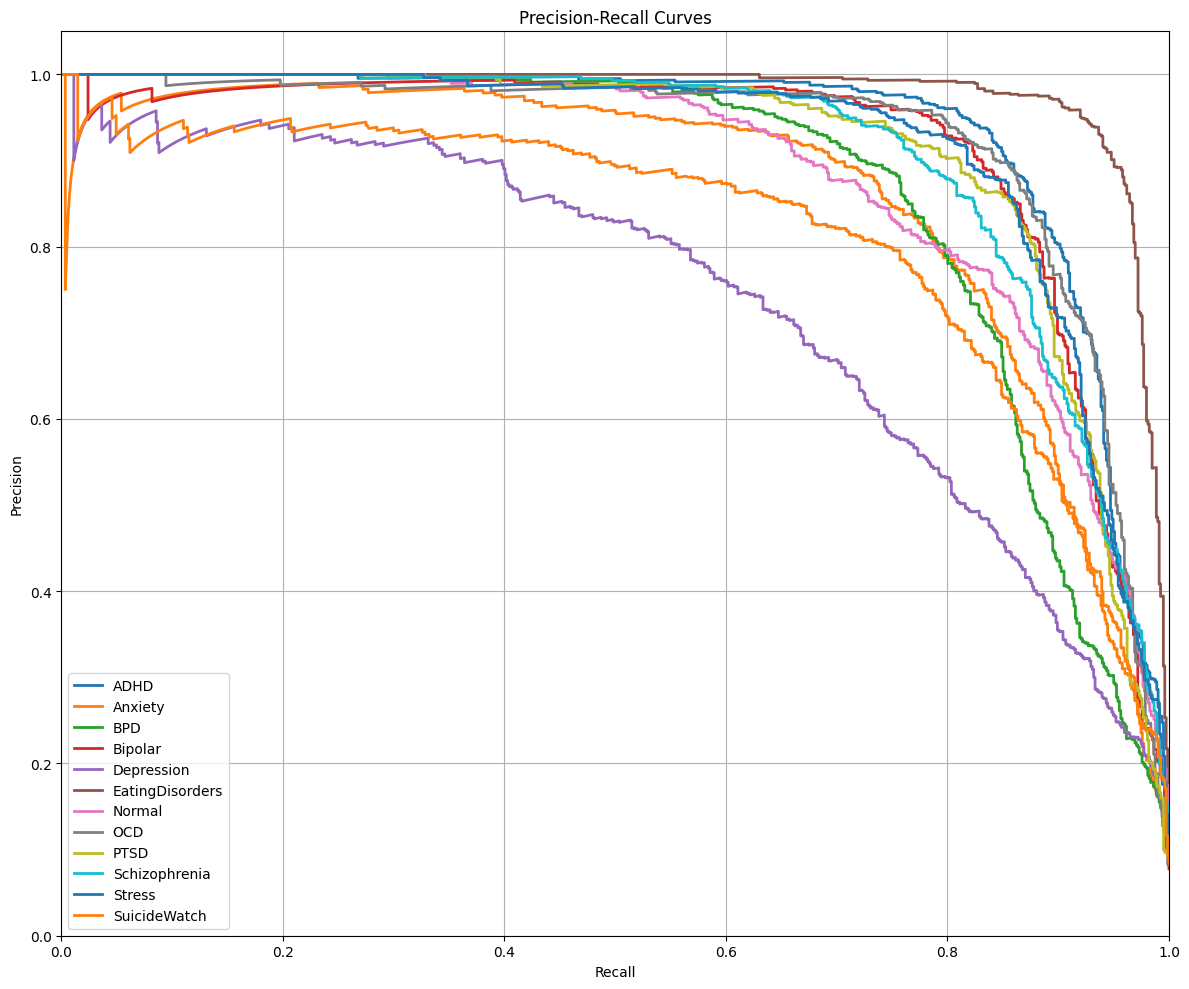

In [28]:
# Cell 17: Plot precision-recall curves
def plot_precision_recall_curves(model, X_test_pad, y_test, encoder):
    """
    Plot precision-recall curves for each class
    """
    print("Generating precision-recall curves...")

    # Get predictions
    y_pred_prob = model.predict(X_test_pad)
    y_test_cat = to_categorical(y_test.values, num_classes=len(encoder.classes_))

    # Plot precision-recall curve for each class
    plt.figure(figsize=(12, 10))

    for i, class_name in enumerate(encoder.classes_):
        precision, recall, _ = precision_recall_curve(y_test_cat[:, i], y_pred_prob[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_precision_recall_curves(cnn_model, X_test_pad, y_test, encoder)

In [29]:
# Cell 22: Create an interactive prediction tool
def create_interactive_prediction_tool(model, tokenizer, encoder, MAX_SEQUENCE_LENGTH):
    """
    Create an interactive prediction tool with visualized probabilities
    """
    from ipywidgets import widgets
    from IPython.display import display, clear_output

    print("Creating interactive prediction tool...")

    # Create widgets
    text_input = widgets.Textarea(
        value='',
        placeholder='Enter text to classify...',
        description='Input:',
        disabled=False,
        layout={'width': '100%', 'height': '100px'}
    )

    analyze_button = widgets.Button(
        description='Analyze',
        button_style='success',
        tooltip='Click to analyze the text'
    )

    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output()
            if not text_input.value.strip():
                print("Please enter some text first!")
                return

            # Preprocess the text
            sequence = tokenizer.texts_to_sequences([text_input.value])
            padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

            # Get prediction probabilities
            prediction = model.predict(padded_sequence)[0]

            # Sort classes by probability
            sorted_indices = prediction.argsort()[::-1]

            # Display results
            plt.figure(figsize=(10, 6))
            classes = [encoder.classes_[i] for i in sorted_indices]
            probs = [prediction[i] * 100 for i in sorted_indices]

            # Plot bar chart
            bars = plt.bar(classes, probs, color='skyblue')
            plt.xlabel('Disorder')
            plt.ylabel('Probability (%)')
            plt.title('Prediction Probabilities')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

            # Annotate bars with exact percentages
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%',
                        ha='center', va='bottom', rotation=0)

            plt.show()

            # Print top 3 predictions with probabilities
            print("Top 3 predictions:")
            for i in range(3):
                idx = sorted_indices[i]
                disorder = encoder.classes_[idx]
                probability = prediction[idx] * 100
                print(f"{disorder}: {probability:.2f}%")

    analyze_button.on_click(on_button_click)

    # Display widgets
    display(text_input)
    display(analyze_button)
    display(output)

    print("Interactive tool is ready! Enter text and click 'Analyze'.")

# Example usage:
create_interactive_prediction_tool(cnn_model, tokenizer, encoder, MAX_SEQUENCE_LENGTH)

Creating interactive prediction tool...


Textarea(value='', description='Input:', layout=Layout(height='100px', width='100%'), placeholder='Enter text …

Button(button_style='success', description='Analyze', style=ButtonStyle(), tooltip='Click to analyze the text'…

Output()

Interactive tool is ready! Enter text and click 'Analyze'.


In [17]:
# Cell 22: Create an interactive prediction tool
def create_interactive_prediction_tool(model, tokenizer, encoder, MAX_SEQUENCE_LENGTH):
    """
    Create an interactive prediction tool with visualized probabilities
    """
    from ipywidgets import widgets
    from IPython.display import display, clear_output

    print("Creating interactive prediction tool...")

    # Create widgets
    text_input = widgets.Textarea(
        value='',
        placeholder='Enter text to classify...',
        description='Input:',
        disabled=False,
        layout={'width': '100%', 'height': '100px'}
    )

    analyze_button = widgets.Button(
        description='Analyze',
        button_style='success',
        tooltip='Click to analyze the text'
    )

    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output()
            if not text_input.value.strip():
                print("Please enter some text first!")
                return

            # Preprocess the text
            sequence = tokenizer.texts_to_sequences([text_input.value])
            padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

            # Get prediction probabilities
            prediction = model.predict(padded_sequence)[0]

            # Sort classes by probability
            sorted_indices = prediction.argsort()[::-1]

            # Display results
            plt.figure(figsize=(10, 6))
            classes = [encoder.classes_[i] for i in sorted_indices]
            probs = [prediction[i] * 100 for i in sorted_indices]

            # Plot bar chart
            bars = plt.bar(classes, probs, color='skyblue')
            plt.xlabel('Disorder')
            plt.ylabel('Probability (%)')
            plt.title('Prediction Probabilities')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

            # Annotate bars with exact percentages
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%',
                        ha='center', va='bottom', rotation=0)

            plt.show()

            # Print top 3 predictions with probabilities
            print("Top 3 predictions:")
            for i in range(3):
                idx = sorted_indices[i]
                disorder = encoder.classes_[idx]
                probability = prediction[idx] * 100
                print(f"{disorder}: {probability:.2f}%")

    analyze_button.on_click(on_button_click)

    # Display widgets
    display(text_input)
    display(analyze_button)
    display(output)

    print("Interactive tool is ready! Enter text and click 'Analyze'.")

# Example usage:
create_interactive_prediction_tool(cnn_model, tokenizer, encoder, MAX_SEQUENCE_LENGTH)

Creating interactive prediction tool...


Textarea(value='', description='Input:', layout=Layout(height='100px', width='100%'), placeholder='Enter text …

Button(button_style='success', description='Analyze', style=ButtonStyle(), tooltip='Click to analyze the text'…

Output()

Interactive tool is ready! Enter text and click 'Analyze'.


In [ ]:
# Cell 23: Implement model on CSV file with statements
def classify_statements_from_csv(model, tokenizer, encoder, MAX_SEQUENCE_LENGTH, csv_file_path, output_file_path=None):
    """
    Classify statements from a CSV file and save results to a new CSV file

    Parameters:
    - model: Trained model
    - tokenizer: Fitted tokenizer
    - encoder: Label encoder
    - MAX_SEQUENCE_LENGTH: Maximum sequence length for padding
    - csv_file_path: Path to input CSV file with 'statement' column
    - output_file_path: Path to output CSV file (default: input_file_predictions.csv)

    Returns:
    - DataFrame with original statements and predictions
    """
    print(f"Processing statements from {csv_file_path}...")

    # Set default output path if not specified
    if output_file_path is None:
        output_file_path = csv_file_path.replace('.csv', '_predictions.csv')
        if output_file_path == csv_file_path:  # If no .csv in filename
            output_file_path = csv_file_path + '_predictions.csv'

    try:
        # Load the CSV file
        df = pd.read_csv(csv_file_path)

        # Check if 'statement' column exists
        if 'statement' not in df.columns:
            print("Error: CSV file must contain a 'statement' column")
            return None

        print(f"Loaded {len(df)} statements from CSV file")

        # Preprocess statements
        statements = df['statement'].fillna("").astype(str).tolist()
        sequences = tokenizer.texts_to_sequences(statements)
        padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

        print(f"Processing batches of statements...")

        # Make predictions in batches to avoid memory issues
        batch_size = 32
        all_predictions = []

        for i in range(0, len(padded_sequences), batch_size):
            batch = padded_sequences[i:i+batch_size]
            batch_predictions = model.predict(batch)
            all_predictions.append(batch_predictions)

            # Print progress
            if (i + batch_size) % (batch_size * 10) == 0 or i + batch_size >= len(padded_sequences):
                print(f"Processed {min(i + batch_size, len(padded_sequences))}/{len(padded_sequences)} statements")

        # Combine all batch predictions
        predictions = np.vstack(all_predictions)

        # Get the predicted class indices and probabilities
        pred_indices = np.argmax(predictions, axis=1)
        pred_probs = np.max(predictions, axis=1)

        # Convert indices to class names
        pred_classes = encoder.inverse_transform(pred_indices)

        # Create results DataFrame
        results_df = df.copy()
        results_df['predicted_disorder'] = pred_classes
        results_df['confidence'] = pred_probs * 100

        # Add top 3 predictions and their confidences
        disorder_names = encoder.classes_

        # Add columns for top 3 predictions
        for i in range(3):
            # Get indices of i-th highest probability for each row
            top_indices = np.argsort(predictions, axis=1)[:, -(i+1)]
            results_df[f'top_{i+1}_disorder'] = encoder.inverse_transform(top_indices)
            results_df[f'top_{i+1}_confidence'] = np.array([predictions[j, idx] * 100 for j, idx in enumerate(top_indices)])

        # Save results to CSV
        results_df.to_csv(output_file_path, index=False)
        print(f"Results saved to {output_file_path}")

        # Print summary statistics
        print("\nSummary of predictions:")
        disorder_counts = results_df['predicted_disorder'].value_counts()
        for disorder, count in disorder_counts.items():
            percentage = count / len(results_df) * 100
            print(f"{disorder}: {count} instances ({percentage:.2f}%)")

        return results_df

    except Exception as e:
        print(f"Error processing CSV file: {e}")
        return None

# Example usage:
results_df = classify_statements_from_csv(cnn_model, tokenizer, encoder, MAX_SEQUENCE_LENGTH, '/content/Combined_Data_Cleaned.csv')

Processing statements from /content/Combined_Data_Cleaned.csv...
Loaded 53043 statements from CSV file
Processing batches of statements...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Processed 320/53043 statements
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Processed 640/53043 statements
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
